# What are Target Pixel File objects?

Target Pixel Files (TPFs) are a file common to Kepler/K2 and the TESS mission. They contain data that is usually centered around a single star.

TPFs can be thought of as stacks of images, with one image for every timestamp the telescope took data. Each timestamp is referred to as a **cadence**. These images are cut out 'postage stamps' of the full observation to make them easier to work with. 

TPFs are given in FITS files, which you can read more about [here](https://fits.gsfc.nasa.gov/fits_primer.html). `lightkurve` includes tools for you to work directly with these files easily and intuitively.

In this tutorial we'll cover the basics of working with TPFs. In lightcurve there are classes to work with each mission. For example `KeplerTargetPixelFile` is used to work with data from the Kepler (and K2) mission. `TessTargetPixelFile` is used to work with data from the TESS mission.

We'll use a Kepler TPF as an example. First, let's open a file. We can do this easily with the `KeplerTargetPixelFile.from_archive` function. This will retrieve the data from the [MAST data archive](https://archive.stsci.edu/kepler/), which holds all of the Kepler and K2 data.
In this case we are downloading the Target Pixel File with the Kepler ID 6922244 for Quarter 4 (Kepler's observations were split into quarters of a year).
You can also download a file with `from_archive` using the name of the target, or using the astronomical coordinates (Right Ascension and Declination, often referred to as "RA" and "Dec").

## KeplerTargetPixelFile downloading data from [MAST data archive](https://archive.stsci.edu/kepler/)

In [1]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive(6922244, quarter=4)

We can access lots of meta data using this object very simply with properties of the `KeplerTargetPixelFile` object. For example, we can find the mission name, and the quarter that the data was taken in by typing the following:

In [2]:
tpf.mission

'Kepler'

In [3]:
tpf.quarter

4

You can find the full list of properties in the [API documentation](http://lightkurve.keplerscience.org/api/targetpixelfile.html).

The most interesting data in a `KeplerTargetPixelFile` object are the `flux` and `time` values which give access to the brightness of the observed target over time. You can access the timestamps of the observations using the `time` property:

In [4]:
tpf.time

array([352.37632485, 352.39675805, 352.43762445, ..., 442.16263546,
       442.18306983, 442.2035041 ])

By default, `time` is in the Kepler-specific *Barycentric Kepler Julian Day* format (BKJD). You can easily convert this into [AstroPy Time objects](http://docs.astropy.org/en/stable/time/) using the `astropy_time` property:

In [5]:
tpf.astropy_time

<Time object: scale='tdb' format='jd' value=[2455185.37632485 2455185.39675805 2455185.43762445 ... 2455275.16263546
 2455275.18306983 2455275.2035041 ]>

In turn, this gives you access to human-readable ISO timestamps using the `astropy_time.iso` property:

In [6]:
tpf.astropy_time.iso

array(['2009-12-19 21:01:54.467', '2009-12-19 21:31:19.895',
       '2009-12-19 22:30:10.752', ..., '2010-03-19 15:54:11.704',
       '2010-03-19 16:23:37.233', '2010-03-19 16:53:02.754'], dtype='<U23')

**Beware:** these ISO timestamps are in the Barycentric frame, and do not include corrections for light travel time or leap seconds.

Next, let's look at the actual image data, which is available via the `flux` property:

In [7]:
tpf.flux.shape

(4116, 5, 5)

The `flux` data is a 4116x5x5 array in units electrons/second. The first axis is the time axis, and the images themselves are 5 pixels by 5 pixels. You can use the `plot` method on the `KeplerTargetPixelFile` object to view the data. (By default, this will show just one cadence of the data. But you can pass the cadence you want to look at to the `frame` keyword if you would like to check a particular flux point for thruster firings, cosmic rays or asteroids.)

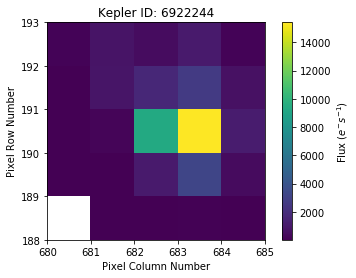

In [8]:
%matplotlib inline
tpf.plot(frame=0);

The values shown in this image are also directly accessible as an array:

In [9]:
tpf.flux[0]

array([[          nan, 5.6079335e+00, 5.1491142e+01, 8.4241745e+01,
        3.0221334e+01],
       [4.4045620e+01, 7.6861229e+01, 1.1227759e+03, 3.2262029e+03,
        4.5486777e+02],
       [2.5911165e+01, 2.2907593e+02, 9.3626543e+03, 2.3606273e+04,
        1.2087750e+03],
       [4.0100830e+01, 8.8543927e+02, 1.7102118e+03, 2.6254871e+03,
        7.0796606e+02],
       [1.5719417e+02, 8.3713440e+02, 5.1021539e+02, 1.1501041e+03,
        1.8313370e+02]], dtype=float32)

You can use normal `numpy` methods on these to find the shape, mean etc!

We can now turn this Target Pixel File into a light curve, with a single flux value for every time value. Each of the pixels are 4 arcseconds across. The point spread function (PSF) of the telescope causes the light from the star fall onto several different pixels, which can be seen in the image above. Because of this spreading, we have to sum up many pixels to collect all the light from the source. To do this we sum up all the pixels in an **aperture**. An aperture is a pixel mask, where we take only the pixels related to the target. 

The *Kepler* pipeline adds an aperture mask to each target pixel file. This aperture determines which pixels are summed to create a 1D light curve of the target. There are some science cases where you might want to create a different aperture. For example, there may be a nearby contaminant or you may want to measure the background. 

The standard pipeline aperture is easily accessed in a `KeplerTargetPixelFile` object using `tpf.pipeline_mask`, which is a boolean array:

In [10]:
tpf.pipeline_mask

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False,  True, False]])

We can also plot this aperture over the target pixel file above to see if the flux of the star is all contained within the aperture.

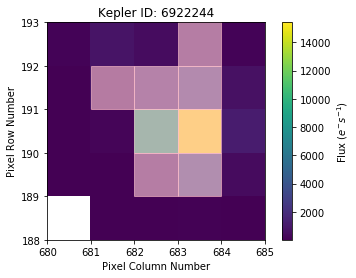

In [11]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

Now that we have the aperture we can create a Simple Aperture Photometry light curve in the next tutorial.

Finally, note that you can inspect all the raw metadata of the target by taking a look at the 'header' of the FITS file, which contains information about the data set. Let's just print the first 10 lines:

In [12]:
tpf.header()[:10]

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-23'         / file creation date.                            
CREATOR = '917482 TargetPixelExporterPipelineModule' / pipeline job and program 

We can look at the values in the second extention of the fits file by passing an extention number to the `header` function. For example, to look at all the column titles:

In [13]:
tpf.header(1)['TTYPE*']

TTYPE1  = 'TIME    '           / column title: data time stamps                 
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TTYPE3  = 'CADENCENO'          / column title: unique cadence number            
TTYPE4  = 'RAW_CNTS'           / column title: raw pixel counts                 
TTYPE5  = 'FLUX    '           / column title: calibrated pixel flux            
TTYPE6  = 'FLUX_ERR'           / column title: 1-sigma calibrated uncertainty   
TTYPE7  = 'FLUX_BKG'           / column title: calibrated background flux       
TTYPE8  = 'FLUX_BKG_ERR'       / column title: 1-sigma cal. background uncertain
TTYPE9  = 'COSMIC_RAYS'        / column title: cosmic ray detections            
TTYPE10 = 'QUALITY '           / column title: pixel quality flags              
TTYPE11 = 'POS_CORR1'          / column title: column position correction       
TTYPE12 = 'POS_CORR2'          / column title: row position correction          
TTYPE13 = 'RB_LEVEL'        

## KeplerTargetPixelFile loading data from local file

Another way to process TPFs is using `KeplerTargetPixelFile` function and pass as first argument the path file to our **local Kepler Target Pixel File** in our computer.

Additionally we can download the Target Pixel Files from the web site [MAST data archive](https://archive.stsci.edu/kepler/)
* click over **Download Options**
* click over over the **link** under the title **Target Pixel Files**

In [18]:
path_file = 'kepler-target-pixel-files/kplr001429092-2009166043257_lpd-targ.fits.gz'
tpf_local_file = KeplerTargetPixelFile(path_file, quarter=16, quality_bitmask='hardest')

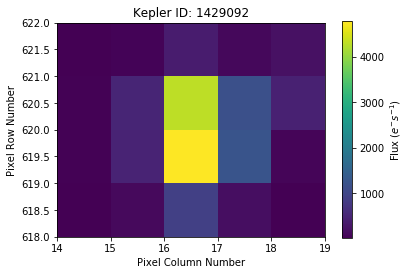

In [19]:
%matplotlib inline
tpf_local_file.plot(frame=1);